## Content:
- **[Part 1](#part1)- Importing the data set, packages used**
- **[Part 2](#part2)- Preprocessing Data**
- **[Part 3](#part3) -  Logistic Regression**
- **[Part 4](#part4) -  ANN with one Hidden Layer**
- **[Part 5](#part5) -  ANN with two Hidden Layers**
- **[Part 6](#part6) - ANN with three Hidden Layers**



[Back to top](#Content:)


<a id='part1'></a>

# Part 1 -  Importing the data set

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

In [2]:
random.seed(0)

In [3]:
# Loading Dataset
df = pd.read_csv("healthcare/train_data.csv", na_values=['NA', '?'])

In [4]:
# Dropping na values for 
df = df.dropna()

In [5]:
# Dropping case_id
df.drop(['case_id'], axis=1, inplace=True)

[Back to top](#Content:)


<a id='part2'></a>

# Part 2 -  Preprocessing Data

### Hot Encoded Data

In [6]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) 

In [7]:
from sklearn.preprocessing import LabelEncoder 
# Columns where we use Label Encoding
le_string_columns = ['Severity of Illness', 'Age' ]
# Columns where we use One Hot Encoding
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()

## label_encoded data
Xe = df.drop(['Stay'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = df['Stay']
ye = encoder.fit_transform(ye)

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

### Scaling and splitting Data

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

# Models

We will use the best models from our last analysis :
- Random Forest
- ANN Classifier



In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

[Back to top](#Content:)


<a id='part3'></a>

# Part 3 -  Class 0 vs All

## Preparing Data

In [17]:
y_train0 = np.minimum(1, y_train)
y_test0 = np.minimum(1, y_test)

## Random Forest

In [18]:
# Instantiating and fitting the data
forest0 = RandomForestClassifier(n_estimators=60, criterion='entropy')
forest0.fit(X_train, y_train0)

RandomForestClassifier(criterion='entropy', n_estimators=60)

Accuracy : 0.926


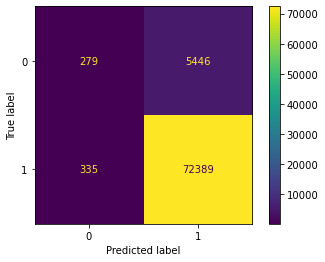

In [23]:
y_pred = forest0.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test0, y_pred))

cm = confusion_matrix(y_test0, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score,roc_curve, auc, roc_auc_score
print("Test Precision-",round(precision_score(y_test0, y_pred),3))
print("Test Recall-",round(recall_score(y_test0, y_pred),3))
print("Test ROCAUC", round(roc_auc_score(y_test0, y_pred),3))

Test Precision- 0.93
Test Recall- 0.995
Test ROCAUC 0.522


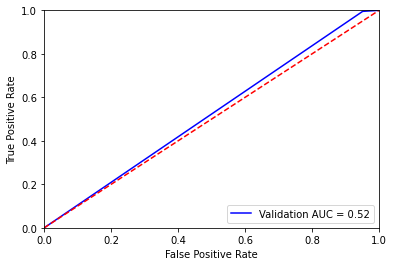

In [25]:
#Validation
fpr_v, tpr_v, _ = roc_curve(y_test0, y_pred)
roc_auc_v = auc(fpr_v, tpr_v)
plt.plot(fpr_v, tpr_v, 'b', label = 'Validation AUC = %0.2f' % roc_auc_v)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Bad classifier, misses a lot

## ANN

In [30]:
model0 = Sequential()
model0.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model0.add(Dense(1,activation='sigmoid'))
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
r = model0.fit(X_train,y_train0,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=50)



Train on 188275 samples, validate on 47069 samples
Epoch 1/50
188275/188275 [==============================] - 8s 44us/sample - loss: 0.2405 - accuracy: 0.9234 - val_loss: 0.2329 - val_accuracy: 0.9238
Epoch 2/50
188275/188275 [==============================] - 7s 37us/sample - loss: 0.2252 - accuracy: 0.9262 - val_loss: 0.2287 - val_accuracy: 0.9236
Epoch 3/50
188275/188275 [==============================] - 7s 37us/sample - loss: 0.2208 - accuracy: 0.9262 - val_loss: 0.2242 - val_accuracy: 0.9242
Epoch 4/50
188275/188275 [==============================] - 7s 37us/sample - loss: 0.2185 - accuracy: 0.9262 - val_loss: 0.2235 - val_accuracy: 0.9237
Epoch 5/50
188275/188275 [==============================] - 8s 43us/sample - loss: 0.2175 - accuracy: 0.9263 - val_loss: 0.2232 - val_accuracy: 0.9236
Epoch 6/50
188275/188275 [==============================] - 7s 38us/sample - loss: 0.2169 - accuracy: 0.9263 - val_loss: 0.2221 - val_accuracy: 0.9239
Epoch 7/50
188275/188275 [=================

Accuracy : 0.927


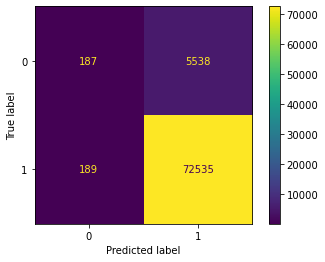

In [35]:
y_pred = model0.predict(X_test) > 0.5
print(f'Accuracy : %.3f' % accuracy_score(y_test0, y_pred))

cm = confusion_matrix(y_test0, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

Both confusion matrices for Random Forest and ANN are disappointing we possibly have to handle the imcalanced data